In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from fipy import CellVariable, Grid1D, TransientTerm, DiffusionTerm, DefaultSolver

In [2]:
def analytical_solution(x, t, L, n_max):
    V = t / L + L / 3
    for n in range(1, n_max + 1):
        V -= 2 * L / (np.pi**2 * n**2) * np.exp(-np.pi**2 * n**2 * t / L**2) * np.cos(np.pi * n * x / L)
    return -2 + 2 * np.sqrt(-x + x**2 / (2 * L) + 1 + V)

In [3]:
def run_fipy(nx, alpha):
    L, T = 1.0, 2.0
    h      = L / nx          # cell width
    dt     = alpha * h**2    # dt ~ h² so that
    nsteps = int(np.ceil(T / dt))

    mesh = Grid1D(nx=nx, dx=h)
    u = CellVariable(mesh=mesh, value=0.0, hasOld=True)
    k = 1 + u/2

    # Robin BC (1+u/2)∂u/∂x = +1 at x=0, Neumann BC 0 at x=L
    u.faceGrad.constrain(-1.0 / k.arithmeticFaceValue, where=mesh.facesLeft)
    u.faceGrad.constrain(0.0,                          where=mesh.facesRight)

    eq = TransientTerm(coeff=k) == DiffusionTerm(coeff=k)
    solver = DefaultSolver()

    for _ in range(nsteps):
        u.updateOld()
        eq.solve(var=u, dt=dt, solver=solver)

    x  = mesh.cellCenters[0].value
    ue = analytical_solution(x, T, L, n_max=120)
    err = np.sqrt(np.mean((u.value - ue)**2))
    return h, err

In [4]:
alpha = 1          # time-step coefficient   (dt = α h²)
nx_min, nx_max = 5, 300
num_steps      = 15  # how many grid levels on a log scale

raw     = np.logspace(np.log10(nx_min), np.log10(nx_max), num=num_steps)
nx_list = np.unique(np.round(raw).astype(int))

hs, errs, times = [], [], []
for nx in nx_list:
    t0 = time.perf_counter()
    h, e = run_fipy(nx, alpha)
    dt_solve = time.perf_counter() - t0
    hs.append(h); errs.append(e); times.append(dt_solve)
    print(f"nx={nx:4d}  h={h:.4e}  L2 err={e:.3e}  time={dt_solve:.2f}s  dt={alpha*h**2:.2e}")

hs    = np.array(hs);  errs = np.array(errs);  times = np.array(times)

nx=   5  h=2.0000e-01  L2 err=7.837e-03  time=0.42s  dt=4.00e-02
nx=   7  h=1.4286e-01  L2 err=1.581e-02  time=0.66s  dt=2.04e-02
nx=   9  h=1.1111e-01  L2 err=2.452e-03  time=1.06s  dt=1.23e-02
nx=  12  h=8.3333e-02  L2 err=1.387e-03  time=1.87s  dt=6.94e-03
nx=  16  h=6.2500e-02  L2 err=7.837e-04  time=3.18s  dt=3.91e-03
nx=  22  h=4.5455e-02  L2 err=4.162e-04  time=6.01s  dt=2.07e-03
nx=  29  h=3.4483e-02  L2 err=9.270e-04  time=10.25s  dt=1.19e-03
nx=  39  h=2.5641e-02  L2 err=5.129e-04  time=18.64s  dt=6.57e-04
nx=  52  h=1.9231e-02  L2 err=7.501e-05  time=33.16s  dt=3.70e-04
nx=  70  h=1.4286e-02  L2 err=1.593e-04  time=60.24s  dt=2.04e-04
nx=  93  h=1.0753e-02  L2 err=2.351e-05  time=106.76s  dt=1.16e-04
nx= 125  h=8.0000e-03  L2 err=1.302e-05  time=193.73s  dt=6.40e-05
nx= 167  h=5.9880e-03  L2 err=7.301e-06  time=350.46s  dt=3.59e-05
nx= 224  h=4.4643e-03  L2 err=1.557e-05  time=638.86s  dt=1.99e-05
nx= 300  h=3.3333e-03  L2 err=2.264e-06  time=1157.27s  dt=1.11e-05



Observed order of convergence  p ≈ 1.97



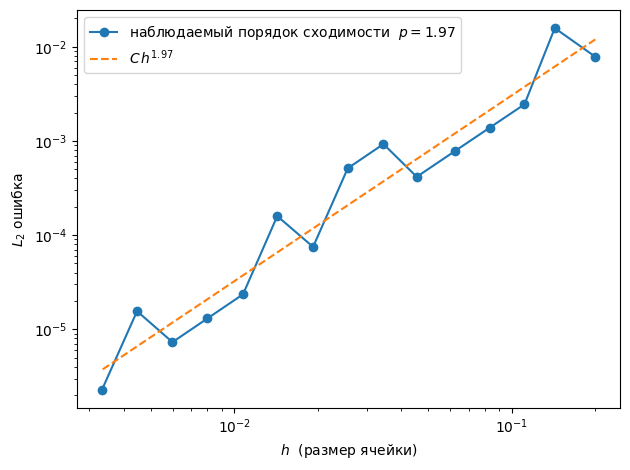

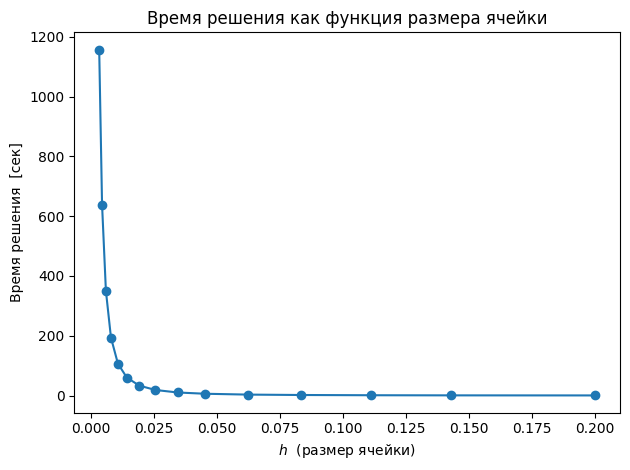

In [5]:
# --- least-squares fit log(err)=p log(h)+log C --------------------------
p_fit, logC = np.polyfit(np.log(hs), np.log(errs), 1)
C_fit = np.exp(logC)
print(f"\nObserved order of convergence  p ≈ {p_fit:.2f}\n")

# --- convergence plot ---------------------------------------------------
plt.figure()
plt.plot(hs, errs, 'o-', label=rf"наблюдаемый порядок сходимости  $p={p_fit:.2f}$")
plt.loglog(hs, C_fit*hs**p_fit, '--', label=rf"$C\,h^{{{p_fit:.2f}}}$")
plt.xlabel(r"$h$  (размер ячейки)")
plt.ylabel(r"$L_2$ ошибка")
#plt.title("Grid-refinement study  (dt ∝ h²)")
plt.legend();  plt.tight_layout()

# --- timing plot --------------------------------------------------------
plt.figure()
plt.plot(hs, times, 'o-')
plt.xlabel(r"$h$  (размер ячейки)")
plt.ylabel("Время решения  [сек]")
plt.title("Время решения как функция размера ячейки")
plt.tight_layout()

plt.show()